In [13]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from tqdm import tqdm
from matplotlib.lines import Line2D
import statannot

from cryptic_rnn import *
from performance_analysis import *

# Functions

## RNN params

In [2]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005
xavier_gain = 0.0001

## running params
epochs = 1800
num_sims = 200

## Sequences

In [135]:
ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print('cue_dict ',cue_dict)
primitives = generate_pos_primitives(all_syms, cue_dict)
print('primitives ',primitives)

trainseqs = generate_pos_other(ops, all_syms[:-1], cue_dict)
trainseqs_b = generate_pos_other(ops, all_syms[:-1], cue_dict) + generate_balanced_primitives(ops, all_syms, cue_dict)
trainseqs_p = trainseqs + primitives
trainseqs_bp = trainseqs_b + primitives

all_seqs = generate_pos_trials('+', all_syms, all_syms, cue_dict, steps = 1) 
testseqs1 = [s for s in all_seqs if s not in trainseqs_p]
testseqs2 = generate_pos_trials('+', all_syms, all_syms, cue_dict, steps = 2) 
testseqs3 = random.sample(generate_pos_trials('+', all_syms, all_syms, cue_dict, steps = 3), 64) 
testseqs4 = random.sample(generate_pos_trials('+', all_syms, all_syms, cue_dict, steps = 4), 64)


cue_dict  {'A': 17, 'B': 14, 'C': 7, 'D': 9}
primitives  [[('+', 'A'), '=', 17], [('+', 'B'), '=', 14], [('+', 'C'), '=', 7], [('+', 'D'), '=', 9]]


In [4]:
save_dir = '../results/train_2seqs/res_20'
with open(save_dir, 'rb') as f:
    res1 = pickle.load(f)


# Performance scores

In [138]:
# extract results
cue_dicts = res1['cue_dicts']
tests = res1['tests']
mods_b = res1['mods_b']
mods_p = res1['mods_p']

In [139]:
# load 2 step test data
test_data_2 = []
for cd in cue_dicts:
    testseqs = change_dict(testseqs2, cd)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    test_data_2.append(DataLoader(test_inputs, batch_size=batchsize, shuffle=True))

test_data_3 = []
for cd in cue_dicts:
    testseqs = change_dict(testseqs3, cd)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    test_data_3.append(DataLoader(test_inputs, batch_size=batchsize, shuffle=True))

test_data_4 = []
for cd in cue_dicts:
    testseqs = change_dict(testseqs4, cd)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    test_data_4.append(DataLoader(test_inputs, batch_size=batchsize, shuffle=True))


In [140]:
r2res_p1 = get_r2_and_preds(mods_p, tests, hidden_size=20)
r2res_b1 = get_r2_and_preds(mods_b, tests, hidden_size=20)

r2res_p2 = get_r2_and_preds(mods_p, test_data_2, hidden_size=20)
r2res_b2 = get_r2_and_preds(mods_b, test_data_2, hidden_size=20)

r2res_p3 = get_r2_and_preds(mods_p, test_data_3, hidden_size=20)
r2res_b3 = get_r2_and_preds(mods_b, test_data_3, hidden_size=20)

r2res_p4 = get_r2_and_preds(mods_p, test_data_4, hidden_size=20)
r2res_b4 = get_r2_and_preds(mods_b, test_data_4, hidden_size=20)

Text(0.5, 1.02, 'RNN predictions against ground truth \n complex addition')

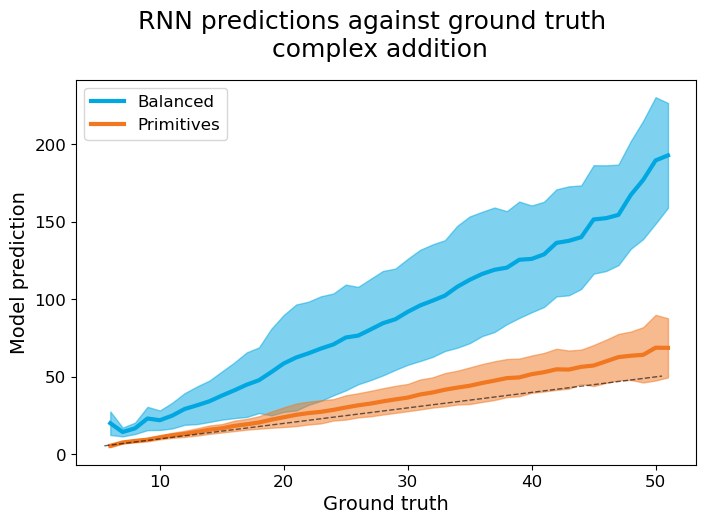

In [39]:
# aggregate all predictions vs labels across models
all_dfs_b = pd.concat(r2res_b['ind_dfs'])
all_dfs_p = pd.concat(r2res_p['ind_dfs'])

labels = ['Balanced', 'Primitives']
plt.rcParams['figure.figsize'] = (8,5)

for i, all_dfs in enumerate([all_dfs_b, all_dfs_p]):
    
    agg_df = all_dfs.groupby(['label']).agg({'pred': ['mean', 'std']})
    yvals = agg_df['pred']['mean']
    yerr = agg_df['pred']['std']
    xvals = agg_df.index
    plt.plot(xvals,yvals, color = bp_colors[i], linewidth=3,label=labels[i])
    plt.fill_between(xvals, yvals - yerr, yvals+yerr, color = bp_colors[i], alpha=0.5)
    xy = np.arange(np.min(yvals),np.max(xvals))
    
plt.plot(xy, xy, color='black', linestyle='dashed',linewidth=1, alpha=0.6)
plt.xlabel('Ground truth')
plt.ylabel('Model prediction')
plt.legend(loc = 'upper left')
plt.suptitle('RNN predictions against ground truth \n complex addition', y=1.02)

In [ ]:
# Individual

In [141]:
N1 = len(r2res_b1['ind_r2s'])
N = len(r2res_b2['ind_r2s'])
r2_scores = np.concatenate([r2res_b1['ind_r2s'], r2res_p1['ind_r2s'], r2res_b2['ind_r2s'], r2res_p2['ind_r2s'],\
                            r2res_b3['ind_r2s'], r2res_p3['ind_r2s'], r2res_b4['ind_r2s'], r2res_p4['ind_r2s']])

steps = [1]*N1*2 + [2]*N*2 + [3]*N*2 + [4]*N*2
curricula = ['Balanced']*N1 + ['Primitives']*N1 + (['Balanced']*N + ['Primitives']*N)*3
r2_df = {'R squared score': r2_scores, 'Curriculum': curricula, 'Steps': steps}


In [157]:
N1*2 + 6*N

5416

In [156]:
np.append(np.repeat([0], N1*2), np.repeat([1,2,4], N*2)).shape

(13540,)

In [163]:
x_jitter = np.append(np.repeat([-0.2, 0.2], N1), np.repeat([0.8, 1.2, 1.8,2.2, 2.8,3.2], N)) + np.random.normal(0,0.05, N1*2 + 6*N)

(-20.0, 2.0)

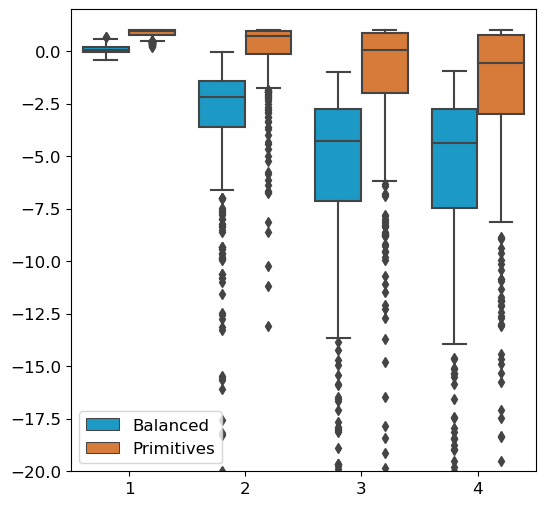

In [177]:
sns.boxplot(data=r2_df,x='Steps',y='R squared score', hue='Curriculum', palette=bp_pal, showfliers = False)
#plt.scatter(x_jitter, r2_df['R squared score'])
plt.ylim(-20,2)
# plt.axhline(y=1)

In [11]:
r2_b = r2res_b['ind_r2s']
r2_p = r2res_p['ind_r2s']
N = len(r2_b)

r2_scores = r2_b + r2_p
regimes = ['Balanced']*N + ['Primitives']*N
r2_df = {'R squared score': r2_scores, 'Regime': regimes}

x_jitter = np.zeros(N) + np.random.normal(0, 0.1, N)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
Balanced v.s. Primitives: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.765e-112 stat=1.900e+01


(<AxesSubplot: xlabel='Curriculum', ylabel='$R^2$'>,
 [<statannot.StatResult.StatResult at 0x7f98d7397a60>])

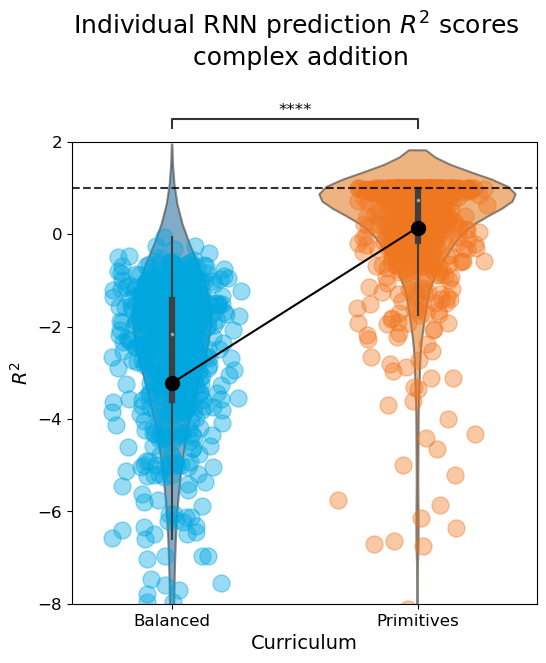

In [56]:
#sns.violinplot(r2_df, x='Regime', y='R squared score', capsize=0.05,errwidth=0.5, palette=bp_pal)

fig, ax = plt.subplots()

sns.violinplot(data=r2_df,x='Regime',y='R squared score')
plt.setp(ax.collections, alpha=.6)
ax.scatter(x_jitter, r2_b, color = bp_colors[0], s=150,  alpha=0.4)
ax.scatter(x_jitter+1, r2_p, color = bp_colors[1], s=150,  alpha=0.4)
ax.plot([0,1], [np.mean(r2_b), np.mean(r2_p)], marker='o', color='black', markersize=10)
ax.set_xticks([0,1])
ax.set_xticklabels(['Balanced','Primitives'])
ax.set_xlabel('Curriculum')
ax.set_ylim(-8, 2)
ax.axhline(y=1, color='black', linestyle = '--', alpha=0.8)
ax.set_ylabel('$R^2$')
plt.suptitle('Individual RNN prediction $R^2$ scores\n complex addition', y=1.1)

statannot.add_stat_annotation(
    ax,
    data=r2_df,
    x='Regime',
    y='R squared score',
    box_pairs=[('Balanced', 'Primitives')],
    test="Wilcoxon",
    text_format="star",
    loc="outside",
)


# MSE Analysis

In [46]:
def testset_MSELoss(res1, testsets, hidden_size=20):
    mods_b = res1['mods_b']
    mods_p = res1['mods_p']
    criterion = nn.MSELoss()
    mse_b = []
    mse_p = []
    for i in range(len(mods_b)):
        mse_b.append(test_modloss(mods_b[i], [testsets[i]], criterion, hidden_size)[0]) 
        mse_p.append(test_modloss(mods_p[i], [testsets[i]], criterion, hidden_size)[0]) 
    return {'mse_b': mse_b, 'mse_p': mse_p}


In [111]:
lossres1 = extract_MSELoss(res1)


In [47]:
lossres = testset_MSELoss(res1, test_data_2)

In [60]:
lossesb = np.sqrt(lossres['mse_b'])
lossesp = np.sqrt(lossres['mse_p'])
curricula = ['Balanced']*len(lossesb) + ['Primitives']*len(lossesp)
rmse = np.append(lossesb, lossesp)

rmse_df = pd.DataFrame({'Curriculum':curricula, 'RMSE':rmse})

N = len(lossesb)
x_jitter = np.repeat([0], N) + np.random.normal(0, 0.03, N)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
Balanced v.s. Primitives: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.623e-112 stat=0.000e+00


(<AxesSubplot: title={'center': 'Complex addition'}, xlabel='Curriculum', ylabel='RMSE'>,
 [<statannot.StatResult.StatResult at 0x7f98b17a1a00>])

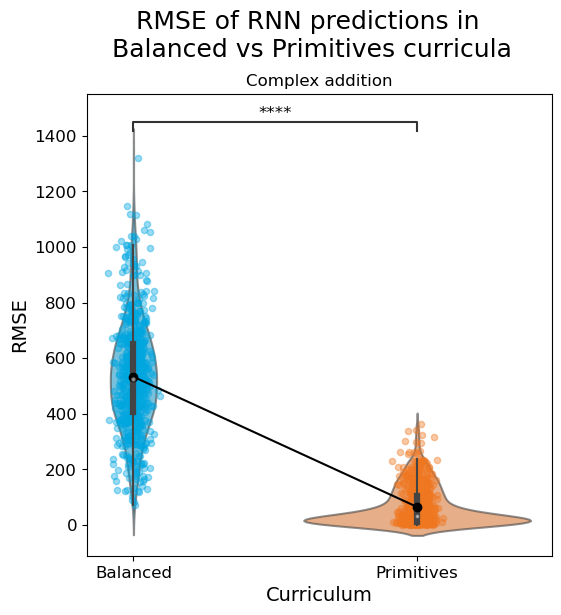

In [73]:
fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = (6,6)
sns.violinplot(data=rmse_df, x='Curriculum', y='RMSE', capsize=0.1, palette=bp_pal, errwidth=1)
plt.setp(ax.collections, alpha=.6)
y_p = [np.mean(lossesb), np.mean(lossesp)]
ax.plot([0,1], y_p, color = 'black', marker = 'o')
plt.scatter(x_jitter, lossesb, alpha = 0.4, color = bp_colors[0], s= 20)
plt.scatter(x_jitter+1, lossesp, alpha = 0.4, color = bp_colors[1], s=20)
plt.suptitle('RMSE of RNN predictions in \nBalanced vs Primitives curricula', y=1.02)
ax.title.set_text('Complex addition')
statannot.add_stat_annotation(
    ax,
    data=rmse_df,
    x='Curriculum',
    y='RMSE',
    box_pairs=[('Balanced', 'Primitives')],
    test="Wilcoxon",
    text_format="star",
    loc="inside",
)

In [85]:
lossesb = np.sqrt(lossres3['mse_b'])
lossesp = np.sqrt(lossres3['mse_p'])
curricula = ['Balanced']*len(lossesb) + ['Primitives']*len(lossesp)
rmse = np.append(lossesb, lossesp)

rmse_df = pd.DataFrame({'Curriculum':curricula, 'RMSE':rmse})
N = len(lossesb)
x_jitter = np.repeat([0], N) + np.random.normal(0, 0.03, N)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
Balanced v.s. Primitives: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.623e-112 stat=0.000e+00


(<AxesSubplot: title={'center': 'Complex addition'}, xlabel='Curriculum', ylabel='RMSE'>,
 [<statannot.StatResult.StatResult at 0x7f9890f5fcd0>])

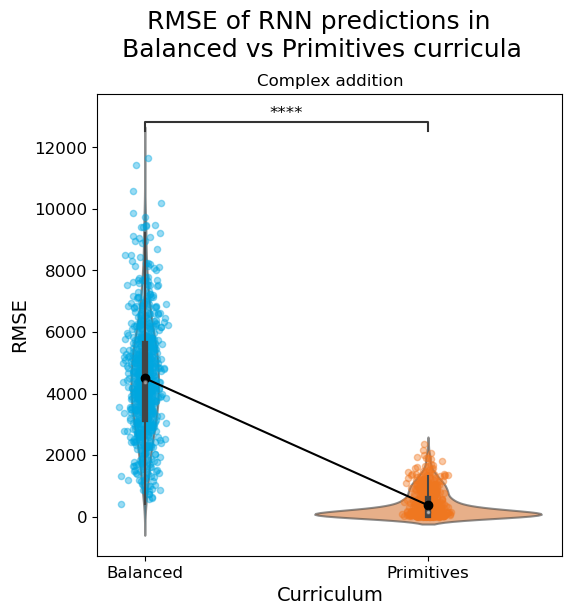

In [92]:
fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = (6,6)
sns.violinplot(data=rmse_df, x='Curriculum', y='RMSE', capsize=0.1, palette=bp_pal, errwidth=1)
plt.setp(ax.collections, alpha=.6)
y_p = [np.mean(lossesb), np.mean(lossesp)]
ax.plot([0,1], y_p, color = 'black', marker = 'o')
plt.scatter(x_jitter, lossesb, alpha = 0.4, color = bp_colors[0], s= 20)
plt.scatter(x_jitter+1, lossesp, alpha = 0.4, color = bp_colors[1], s=20)
plt.suptitle('RMSE of RNN predictions in \nBalanced vs Primitives curricula', y=1.02)
ax.title.set_text('Complex addition')
#ax.set_ylim(0, 1400)
statannot.add_stat_annotation(
    ax,
    data=rmse_df,
    x='Curriculum',
    y='RMSE',
    box_pairs=[('Balanced', 'Primitives')],
    test="Wilcoxon",
    text_format="star",
    loc="inside",
)


In [178]:
lossres1 = testset_MSELoss(res1, tests)
lossres2 = testset_MSELoss(res1, test_data_2)
lossres3 = testset_MSELoss(res1, test_data_3)
lossres4 = testset_MSELoss(res1, test_data_4)

In [179]:
outs1 = np.mean([t[-1] for t in testseqs1])
outs2 = np.mean([t[-1] for t in testseqs2])
outs3 = np.mean([t[-1] for t in testseqs3])
outs4 = np.mean([t[-1] for t in testseqs4])

In [180]:
lossesb1 = np.sqrt(lossres1['mse_b'])/outs1
lossesp1 = np.sqrt(lossres1['mse_p'])/outs1

lossesb2 = np.sqrt(lossres['mse_b'])/outs2
lossesp2 = np.sqrt(lossres['mse_p'])/outs2

lossesb3 = np.sqrt(lossres3['mse_b'])/outs3
lossesp3 = np.sqrt(lossres3['mse_p'])/outs3

lossesb4 = np.sqrt(lossres4['mse_b'])/outs4
lossesp4 = np.sqrt(lossres4['mse_p'])/outs4


N = len(lossesb2)
all_loss = np.concatenate([lossesb1, lossesp1, lossesb2, lossesp2, lossesb3, lossesp3 ,lossesb4, lossesp4])
all_currs = (['Balanced']*N + ['Primitives']*N)*4
num_steps = [1]*N*2 + [2]*N*2 + [3]*N*2 + [4]*N*2

step_df = pd.DataFrame({'Step': num_steps, 'Curriculum': all_currs, 'RMSE': all_loss})

<AxesSubplot: xlabel='Step', ylabel='RMSE'>

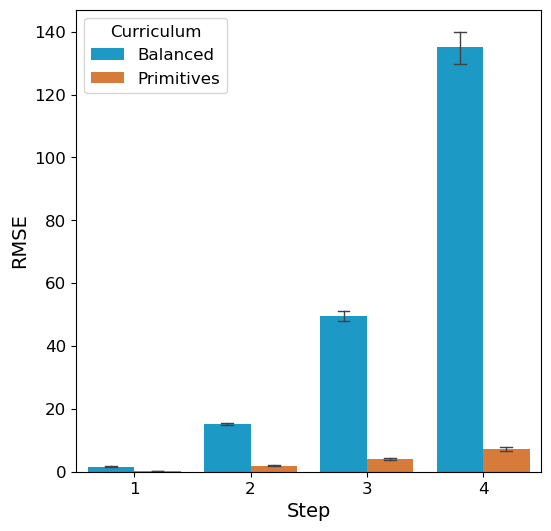

In [181]:
sns.barplot(data=step_df, x= 'Step',y='RMSE', hue='Curriculum', capsize=0.1, palette=bp_pal, errwidth=1)


# RSA

In [74]:
Tmax = 2*len(testseqs[0][:-1])-1-1
allrdms = calculate_RDMs(res1, testseqs, num_classes=22, batchsize=1,hidden_size=20, Tmax=Tmax)

In [75]:
dps = []
for j in range(6):
    dps.append(np.array(allrdms['rdms_p'][j]).mean(axis=0))

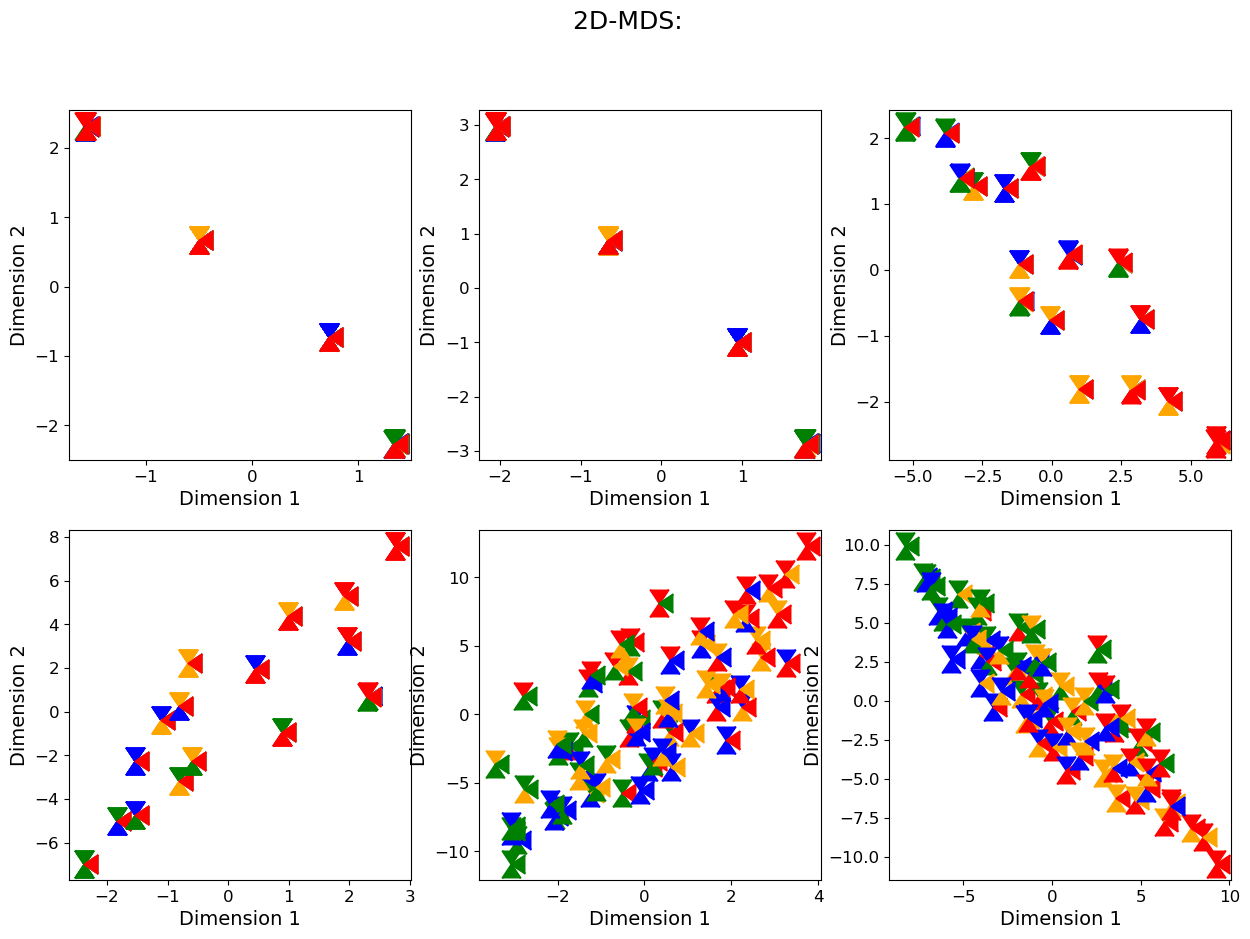

In [79]:
plt.rcParams['figure.figsize'] = (15,10)
fig, ax = plt.subplots(2,3)
ax = ax.flatten()

for i in range(6):
    MDS_plot_single(ax[i], dps[i], testseqs)

In [80]:
dbs = []
for j in range(6):
    dbs.append(np.array(allrdms['rdms_b'][j]).mean(axis=0))

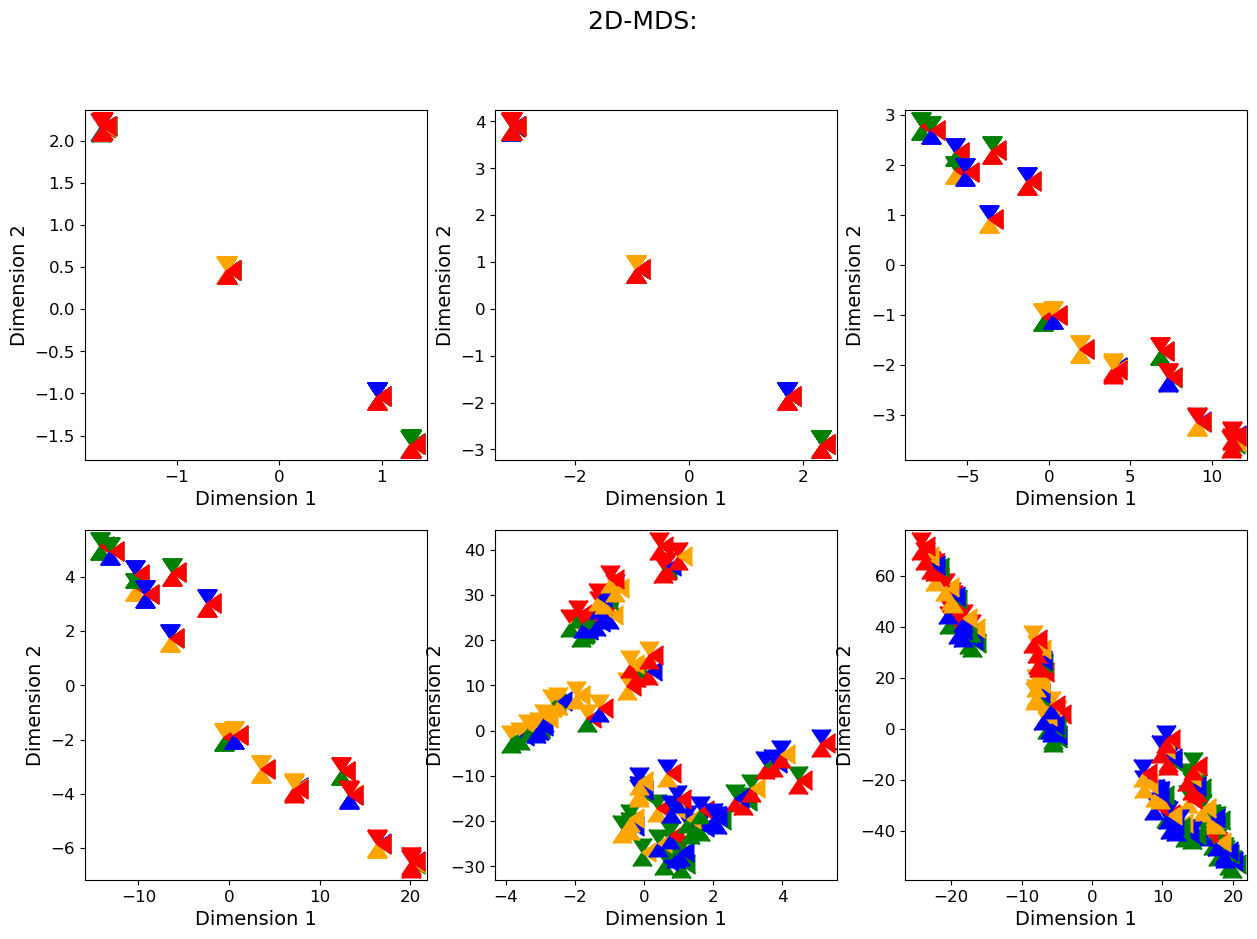

In [81]:
plt.rcParams['figure.figsize'] = (15,10)
fig, ax = plt.subplots(2,3)
ax = ax.flatten()

for i in range(6):
    MDS_plot_single(ax[i], dbs[i], testseqs)

In [183]:
Tmax = 2*len(testseqs3[0][:-1])-1-1
allrdms = calculate_RDMs(res1, testseqs3, num_classes=22, batchsize=1,hidden_size=20, Tmax=Tmax)

In [184]:
dps = []
for j in range(6):
    dps.append(np.array(allrdms['rdms_p'][j]).mean(axis=0))

## 3 steps

In [22]:
Tmax = 2*len(testseqs3[0][:-1])-1-1
allrdms3 = calculate_RDMs(res1, testseqs3, num_classes=22, batchsize=1,hidden_size=20, Tmax=Tmax)

In [192]:
dps3 = []
for j in range(8):
    dps3.append(np.array(allrdms['rdms_p'][j]).mean(axis=0))

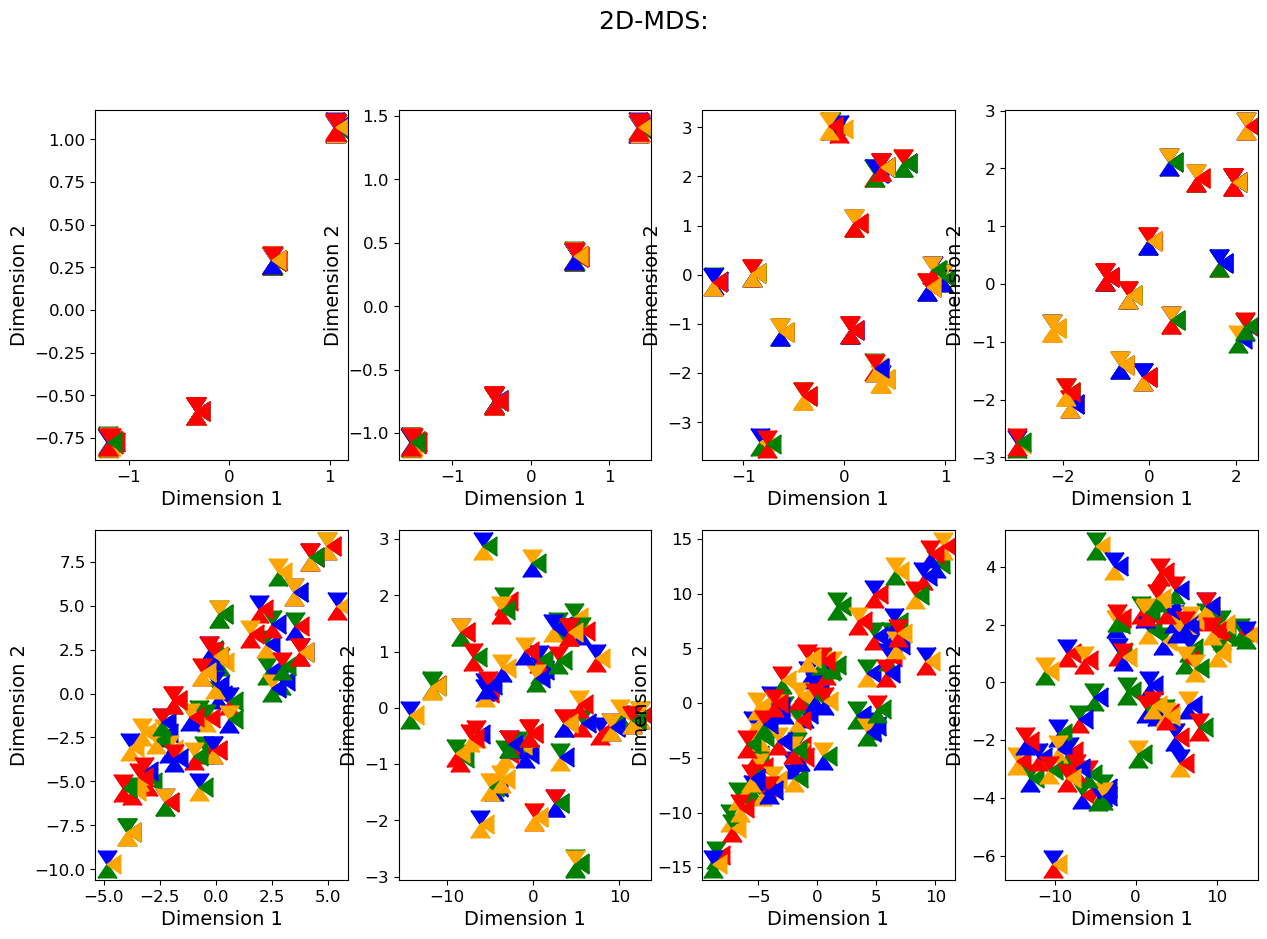

In [193]:
plt.rcParams['figure.figsize'] = (15,10)
fig, ax = plt.subplots(2,4)
ax = ax.flatten()

for i in range(8):
    MDS_plot_single(ax[i], dps3[i], testseqs3)

## Accuracy

In [77]:
colors1 = ([ca]*16 + [cb]*16 + [cc]*16 + [ cd]*16)*2
colors2 = ([ca]*4 + [cb]*4 + [cc]*4 + [ cd]*4)*8
colors3 = [ca, cb, cc, cd]*32

In [78]:
def MDS_plot_single(ax, meanRDM, testseqs, MDStype = 'MDS', title = '', plotlines=True, rand_state=0, min_dim=0):

    if MDStype == 'PCA':
        mds = PCA(n_components=3)
    if MDStype == 'MDS':
        mds = MDS(dissimilarity='precomputed',random_state=rand_state, n_components=3)

    X_transform = mds.fit_transform(meanRDM)
    for i in range(len(testseqs)):
        ax.scatter(X_transform[i,min_dim], X_transform[i,min_dim+1], marker=7, color = colors1[i], s=180)
        ax.scatter(X_transform[i,min_dim], X_transform[i,min_dim+1], marker=6, color = colors2[i], s=180)
        ax.scatter(X_transform[i,min_dim], X_transform[i,min_dim+1], marker=4, color = colors3[i], s=180)
        
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    plt.suptitle('2D-'+MDStype+': '+title)
   

In [14]:
ca, cb, cc, cd = 'green', 'blue', 'orange', 'red'
colors1 = [ca]*4 + [cb]*4 + [cc]*4 + [ cd]*4 + ['black']*4
colors2 = [ca, cb, cc, cd]*4 + [ca, cb, cc, cd]

msize = 12
legend_elements = [Line2D([0], [0], marker=6, color='w', markerfacecolor =ca, markersize=msize, label=' + A _'),
                   Line2D([0], [0], marker=6, color='w', markerfacecolor =cb, markersize=msize, label=' + B _'), 
                   Line2D([0], [0], marker=6, color='w', markerfacecolor =cc, markersize=msize, label=' + C _'),
                   Line2D([0], [0], marker=6, color='w', markerfacecolor =cd, markersize=msize, label=' + D _'),
                   Line2D([0], [0], marker=7, color='w', markerfacecolor=ca, markersize=msize, label=' _ + A'),
                   Line2D([0], [0], marker=7, color='w', markerfacecolor=cb, markersize=msize, label=' _ + B'), 
                   Line2D([0], [0], marker=7, color='w', markerfacecolor=cc, markersize=msize, label=' _ + C'),
                   Line2D([0], [0], marker=7, color='w', markerfacecolor=cd, markersize=msize, label=' _ + D'),
                   Line2D([0], [0], marker='_', color='black', markersize=10, label='primitive')
                   ]


In [34]:
colors1 = ([ca]*16 + [cb]*16 + [cc]*16 + [ cd]*16)*2
colors2 = ([ca]*4 + [cb]*4 + [cc]*4 + [ cd]*4)*8
colors3 = [ca, cb, cc, cd]*32

In [35]:
len(colors2)

128

In [36]:
128/4

32.0

In [139]:
def test_loss(model, testdata, criterion, hidden_size=20):
    model.eval()
    losses_testset = []
    
    for testset in testdata:
        loss_set = 0
        
        for x,y in testset:
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                loss_set += criterion(y_hat,y[i]).item()
     
        losses_testset.append(loss_set)
        
    return losses_testset

In [107]:
criterion = nn.MSELoss()

In [140]:
i = random.randint(0,200)

model = res1['mods_b'][i]
cuedict = res1['cue_dicts'][i]
 
testseqs = change_dict(testseqs, cuedict)
test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
testdata = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)


test_loss(model, [testdata, testdata], criterion)

[1021569.3879394531, 1021569.3879394531]

In [100]:
res1.keys()

dict_keys(['mods', 'mods_b', 'mods_p', 'mods_bp', 'res', 'tests', 'cue_dicts', 'acc_df'])

In [138]:
for i, j in enumerate([3,6,7,8]):
    print(i)

0
1
2
3
